In [ ]:
import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import classification_report, confusion_matrix
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer 
from sklearn.model_selection import train_test_split
from mlxtend.plotting import plot_confusion_matrix
import matplotlib.cm as cm
from matplotlib import rcParams
from collections import Counter
from nltk.tokenize import RegexpTokenizer
import re
import string
from tensorflow.keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer

%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# Importing the dataset
!wget https://github.com/ngtaylor/EE460J-Final-Project/raw/main/data/training.1600000.processed.noemoticon.csv.zip
DATASET_COLUMNS=['target','ids','date','flag','user','text']
DATASET_ENCODING = "ISO-8859-1"
df = pd.read_csv('/content/training.1600000.processed.noemoticon.csv.zip', encoding=DATASET_ENCODING, names=DATASET_COLUMNS)
df.sample(5)

--2021-12-06 05:56:53--  https://github.com/ngtaylor/EE460J-Final-Project/raw/main/data/training.1600000.processed.noemoticon.csv.zip
Resolving github.com (github.com)... 192.30.255.112
Connecting to github.com (github.com)|192.30.255.112|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/ngtaylor/EE460J-Final-Project/main/data/training.1600000.processed.noemoticon.csv.zip [following]
--2021-12-06 05:56:53--  https://raw.githubusercontent.com/ngtaylor/EE460J-Final-Project/main/data/training.1600000.processed.noemoticon.csv.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 84855679 (81M) [application/zip]
Saving to: ‘training.1600000.processed.noemoticon.csv.zip’

training.1600000.pr 100%[=======

target  ...                                               text
1556859       4  ...                              Watching true blood. 
1520501       4  ...            @Waisybabu I am glad one of us got it. 
15843         0  ...  Searched Twitter for #ASOT400: http://tinyurl....
1443925       4  ...  Heading to bed soon. Need to save my pinoy pri...
16894         0  ...  Basically cried through 90% of Rachel Getting ...

[5 rows x 6 columns]

In [ ]:
df.head()

target  ...                                               text
0       0  ...  @switchfoot http://twitpic.com/2y1zl - Awww, t...
1       0  ...  is upset that he can't update his Facebook by ...
2       0  ...  @Kenichan I dived many times for the ball. Man...
3       0  ...    my whole body feels itchy and like its on fire 
4       0  ...  @nationwideclass no, it's not behaving at all....

[5 rows x 6 columns]

In [ ]:
df.columns

Index(['target', 'ids', 'date', 'flag', 'user', 'text'], dtype='object')

In [ ]:
print('length of data is', len(df))

length of data is 1600000


In [ ]:
df.shape

(1600000, 6)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   target  1600000 non-null  int64 
 1   ids     1600000 non-null  int64 
 2   date    1600000 non-null  object
 3   flag    1600000 non-null  object
 4   user    1600000 non-null  object
 5   text    1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


In [ ]:
df.dtypes

target     int64
ids        int64
date      object
flag      object
user      object
text      object
dtype: object

In [ ]:
np.sum(df.isnull().any(axis=1))

0

In [ ]:
print('Count of columns in the data is:  ', len(df.columns))
print('Count of rows in the data is:  ', len(df))

Count of columns in the data is:   6
Count of rows in the data is:   1600000


In [ ]:
df['target'].unique()

array([0, 4])

In [ ]:
df['target'].nunique()

2

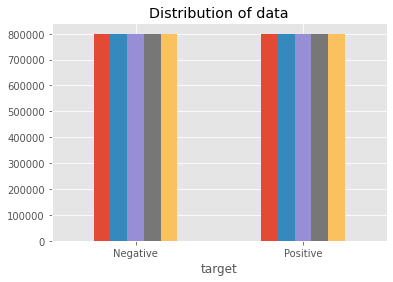

In [ ]:
# Plotting the distribution for dataset.
ax = df.groupby('target').count().plot(kind='bar', title='Distribution of data',legend=False)
ax.set_xticklabels(['Negative','Positive'], rotation=0)
# Storing data in lists.
text, sentiment = list(df['text']), list(df['target'])

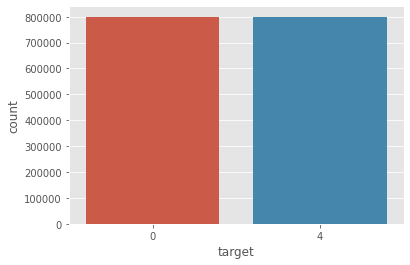

In [ ]:
import seaborn as sns
sns.countplot(x='target', data=df)

In [ ]:
data=df[['text','target']]
data['target'] = data['target'].replace(4,1)
data['target'].unique()


array([0, 1])

In [ ]:
data_pos = data[data['target'] == 1]
data_neg = data[data['target'] == 0]

In [ ]:
data_pos = data_pos.iloc[:int(20000)]
data_neg = data_neg.iloc[:int(20000)]

In [ ]:
dataset = pd.concat([data_pos, data_neg])

In [ ]:
dataset['text']=dataset['text'].str.lower()
dataset['text'].tail()

19995    not much time off this weekend, work trip to m...
19996                            one more day of holidays 
19997    feeling so down right now .. i hate you damn h...
19998    geez,i hv to read the whole book of personalit...
19999    i threw my sign at donnie and he bent over to ...
Name: text, dtype: object

In [ ]:
stopwordlist = ['a', 'about', 'above', 'after', 'again', 'ain', 'all', 'am', 'an',
             'and','any','are', 'as', 'at', 'be', 'because', 'been', 'before',
             'being', 'below', 'between','both', 'by', 'can', 'd', 'did', 'do',
             'does', 'doing', 'down', 'during', 'each','few', 'for', 'from',
             'further', 'had', 'has', 'have', 'having', 'he', 'her', 'here',
             'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in',
             'into','is', 'it', 'its', 'itself', 'just', 'll', 'm', 'ma',
             'me', 'more', 'most','my', 'myself', 'now', 'o', 'of', 'on', 'once',
             'only', 'or', 'other', 'our', 'ours','ourselves', 'out', 'own', 're','s', 'same', 'she', "shes", 'should', "shouldve",'so', 'some', 'such',
             't', 'than', 'that', "thatll", 'the', 'their', 'theirs', 'them',
             'themselves', 'then', 'there', 'these', 'they', 'this', 'those',
             'through', 'to', 'too','under', 'until', 'up', 've', 'very', 'was',
             'we', 'were', 'what', 'when', 'where','which','while', 'who', 'whom',
             'why', 'will', 'with', 'won', 'y', 'you', "youd","youll", "youre",
             "youve", 'your', 'yours', 'yourself', 'yourselves']

In [ ]:
STOPWORDS = set(stopwordlist)
def cleaning_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])
dataset['text'] = dataset['text'].apply(lambda text: cleaning_stopwords(text))
dataset['text'].head()

800000                love @health4uandpets u guys r best!!
800001    im meeting one besties tonight! cant wait!! - ...
800002    @darealsunisakim thanks twitter add, sunisa! g...
800003    sick really cheap hurts much eat real food plu...
800004                      @lovesbrooklyn2 effect everyone
Name: text, dtype: object

In [ ]:
import string
english_punctuations = string.punctuation
punctuations_list = english_punctuations
def cleaning_punctuations(text):
    translator = str.maketrans('', '', punctuations_list)
    return text.translate(translator)
dataset['text']= dataset['text'].apply(lambda x: cleaning_punctuations(x))
dataset['text'].tail()

19995    not much time off weekend work trip malmï¿½ fr...
19996                                     one day holidays
19997                     feeling right  hate damn humprey
19998    geezi hv read whole book personality types emb...
19999    threw sign donnie bent over get but thingee ma...
Name: text, dtype: object

In [ ]:
def cleaning_repeating_char(text):
    return re.sub(r'(.)1+', r'1', text)
dataset['text'] = dataset['text'].apply(lambda x: cleaning_repeating_char(x))
dataset['text'].tail()

19995    not much time off weekend work trip malmï¿½ fr...
19996                                     one day holidays
19997                     feeling right  hate damn humprey
19998    geezi hv read whole book personality types emb...
19999    threw sign donnie bent over get but thingee ma...
Name: text, dtype: object

In [ ]:
def cleaning_URLs(data):
    return re.sub('((www.[^s]+)|(https?://[^s]+))',' ',data)
dataset['text'] = dataset['text'].apply(lambda x: cleaning_URLs(x))
dataset['text'].tail()

19995    not much time off weekend work trip malmï¿½ fr...
19996                                     one day holidays
19997                     feeling right  hate damn humprey
19998    geezi hv read whole book personality types emb...
19999    threw sign donnie bent over get but thingee ma...
Name: text, dtype: object

In [ ]:
def cleaning_numbers(data):
    return re.sub('[0-9]+', '', data)
dataset['text'] = dataset['text'].apply(lambda x: cleaning_numbers(x))
dataset['text'].tail()

19995    not much time off weekend work trip malmï¿½ fr...
19996                                     one day holidays
19997                     feeling right  hate damn humprey
19998    geezi hv read whole book personality types emb...
19999    threw sign donnie bent over get but thingee ma...
Name: text, dtype: object

In [ ]:
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'w+')
dataset['text'] = dataset['text'].apply(tokenizer.tokenize)
dataset['text'].head()

800000           []
800001          [w]
800002    [w, w, w]
800003           []
800004           []
Name: text, dtype: object

In [ ]:
import nltk
st = nltk.PorterStemmer()
def stemming_on_text(data):
    text = [st.stem(word) for word in data]
    return data
dataset['text']= dataset['text'].apply(lambda x: stemming_on_text(x))
dataset['text'].head()

800000           []
800001          [w]
800002    [w, w, w]
800003           []
800004           []
Name: text, dtype: object

In [ ]:
lm = nltk.WordNetLemmatizer()
nltk.download('wordnet')
def lemmatizer_on_text(data):
    text = [lm.lemmatize(word) for word in data]
    return data
dataset['text'] = dataset['text'].apply(lambda x: lemmatizer_on_text(x))
dataset['text'].head()

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


800000           []
800001          [w]
800002    [w, w, w]
800003           []
800004           []
Name: text, dtype: object

In [ ]:
X=data.text
y=data.target

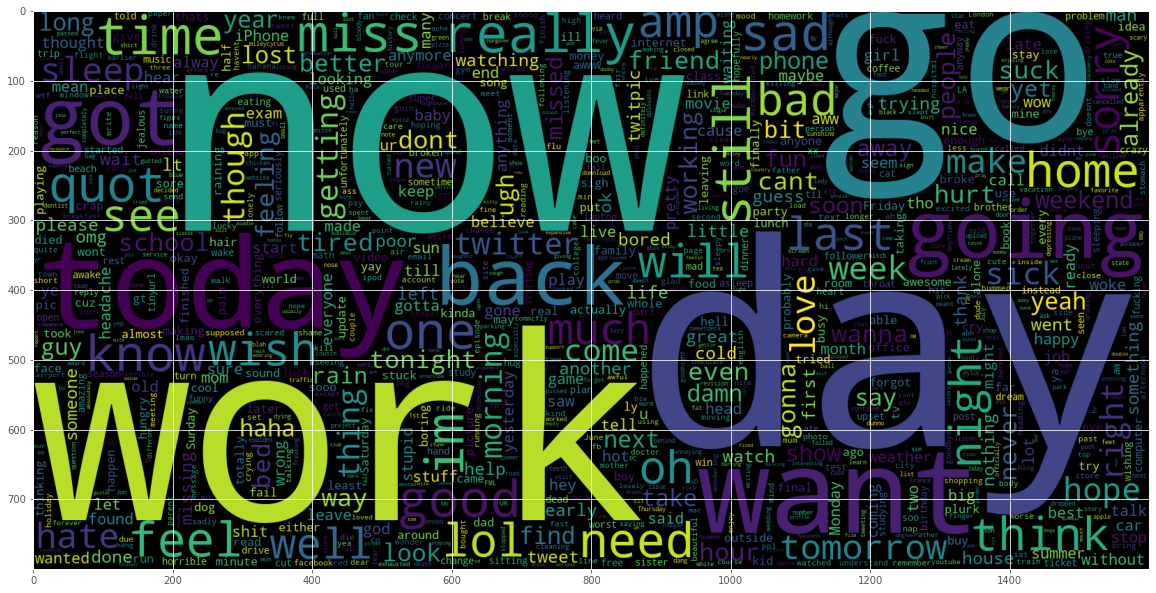

In [ ]:
data_neg = data['text'][:800000]
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
               collocations=False).generate(" ".join(data_neg))
plt.imshow(wc)

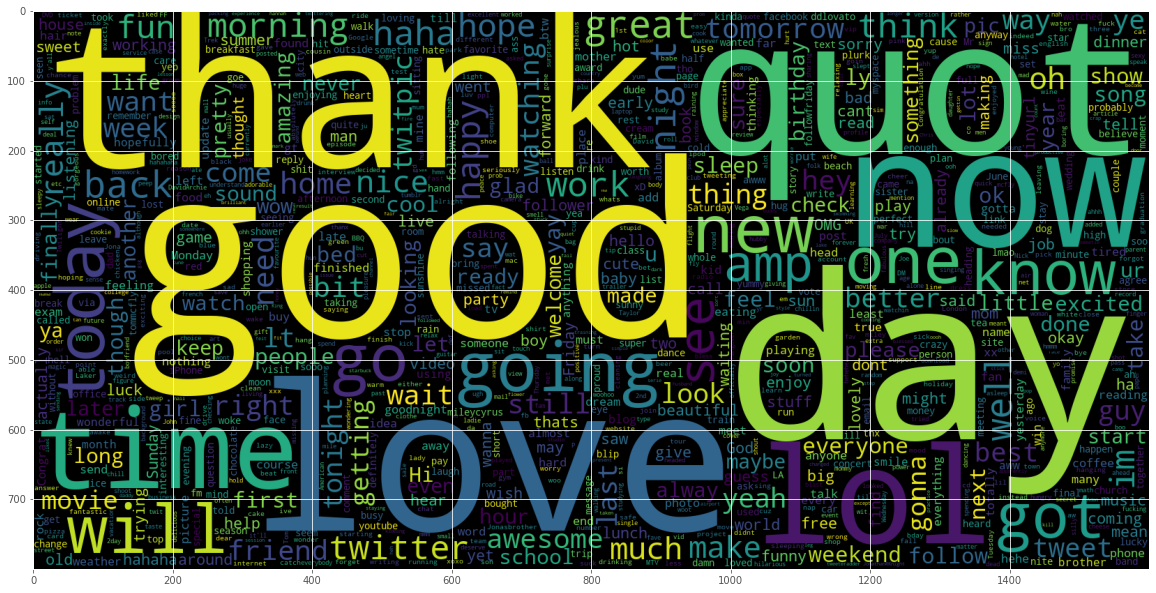

In [ ]:
data_pos = data['text'][800000:]
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
              collocations=False).generate(" ".join(data_pos))
plt.figure(figsize = (20,20))
plt.imshow(wc)

In [ ]:
#vectoriser = TfidfVectorizer(ngram_range=(1,2), max_features=500000)
#vectoriser.fit(X_train)
#print('No. of feature_words: ', len(vectoriser.get_feature_names()))

In [ ]:
#X_train = vectoriser.transform(X_train)
#X_test  = vectoriser.transform(X_test)

In [ ]:
max_len = 500
tok = Tokenizer(num_words=2000)
tok.fit_on_texts(X)
sequences = tok.texts_to_sequences(X)
sequences_matrix = sequence.pad_sequences(sequences,maxlen=max_len)

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(sequences_matrix, y, test_size=0.3, random_state=2)

In [ ]:
def tensorflow_based_model(): #Defined tensorflow_based_model function for training tenforflow based model
    inputs = Input(name='inputs',shape=[max_len])#step1
    layer = Embedding(2000,50,input_length=max_len)(inputs) #step2
    layer = LSTM(64)(layer) #step3
    layer = Dense(256,name='FC1')(layer) #step4
    layer = Activation('relu')(layer) # step5
    layer = Dropout(0.5)(layer) # step6
    layer = Dense(1,name='out_layer')(layer) #step4 again but this time its giving only one output as because we need to classify the tweet as positive or negative
    layer = Activation('sigmoid')(layer) #step5 but this time activation function is sigmoid for only one output.
    model = Model(inputs=inputs,outputs=layer) #here we are getting the final output value in the model for classification
    return model #function returning the value when we call it


In [ ]:
model = tensorflow_based_model() # here we are calling the function of created model
model.compile(loss="binary_crossentropy", optimizer=RMSprop(), metrics=["accuracy"])

history=model.fit(X_train,Y_train,batch_size=80,epochs=30, validation_split=0.1)# here we are starting the training of model by feeding the training data
print('Training finished !!')

Epoch 1/30
12600/12600 [==============================] - 314s 25ms/step - loss: 0.4505 - accuracy: 0.7893 - val_loss: 0.4291 - val_accuracy: 0.8007
Epoch 2/30
12600/12600 [==============================] - 317s 25ms/step - loss: 0.4268 - accuracy: 0.8032 - val_loss: 0.4250 - val_accuracy: 0.8048
Epoch 3/30
12600/12600 [==============================] - 327s 26ms/step - loss: 0.4214 - accuracy: 0.8073 - val_loss: 0.4254 - val_accuracy: 0.8064
Epoch 4/30
12600/12600 [==============================] - 327s 26ms/step - loss: 0.4206 - accuracy: 0.8085 - val_loss: 0.4311 - val_accuracy: 0.8066
Epoch 5/30
12600/12600 [==============================] - 328s 26ms/step - loss: 0.4225 - accuracy: 0.8091 - val_loss: 0.4197 - val_accuracy: 0.8072
Epoch 6/30
12600/12600 [==============================] - 330s 26ms/step - loss: 0.4186 - accuracy: 0.8118 - val_loss: 0.4253 - val_accuracy: 0.8081
Epoch 7/30
12600/12600 [==============================] - 328s 26ms/step - loss: 0.4183 - accuracy: 0.8124

In [ ]:
accr1 = model.evaluate(X_test,Y_test) #we are starting to test the model here


15000/15000 [==============================] - 141s 9ms/step - loss: 0.4484 - accuracy: 0.7969


In [ ]:
print('Test set\n Accuracy: {:0.2f}'.format(accr1[1]))

Test set
 Accuracy: 0.80


In [ ]:
y_pred = model.predict(X_test) #getting predictions on the trained model

In [ ]:
y_preds = y_pred

In [ ]:
y_pred = (y_preds > 0.5)

[[194339  45383]
 [ 52112 188166]]


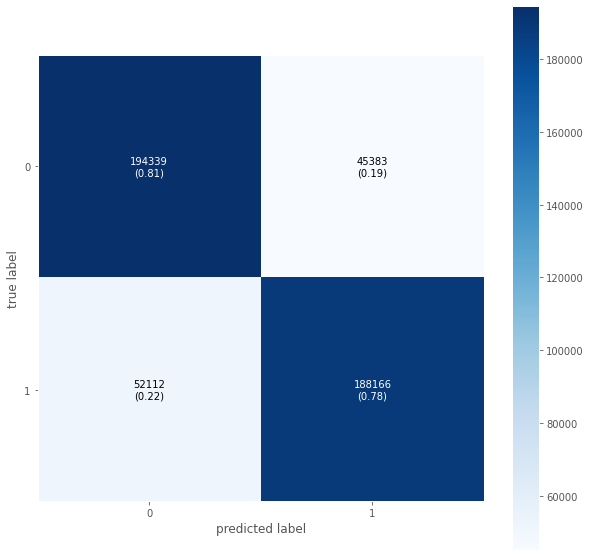

In [ ]:
CR = confusion_matrix(Y_test, y_pred)
print (CR)
fig, ax = plot_confusion_matrix(conf_mat=CR, figsize = (10,10), 
                                show_absolute=True, 
                                show_normed=True, 
                                colorbar=True)

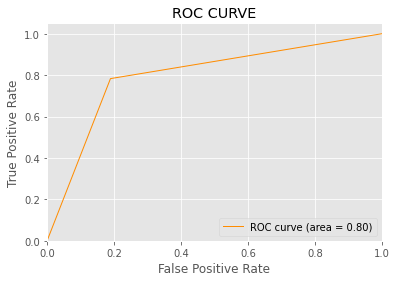

In [ ]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(Y_test, y_pred)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE')
plt.legend(loc="lower right")
plt.show()

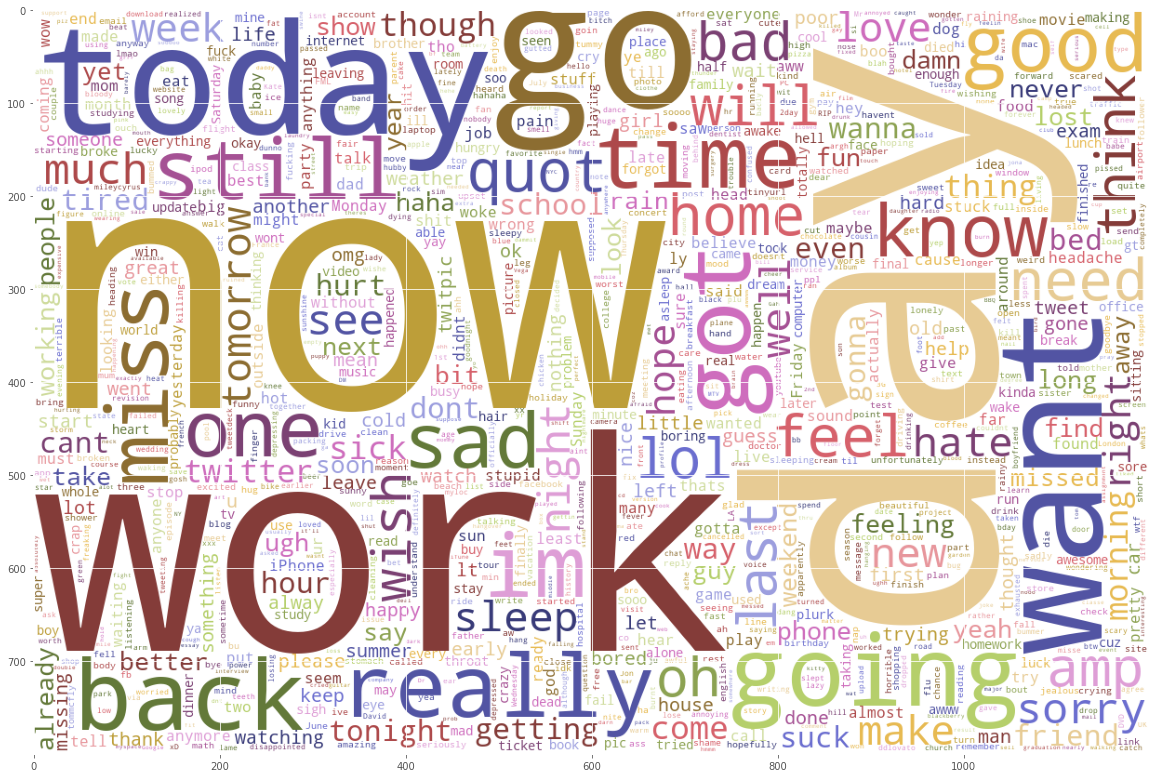

In [ ]:
data_neg = data['text'][:800000]
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 1000 , width = 1200,background_color = "white", colormap='tab20b', height = 800,
               collocations=False).generate(" ".join(data_neg))
plt.imshow(wc)

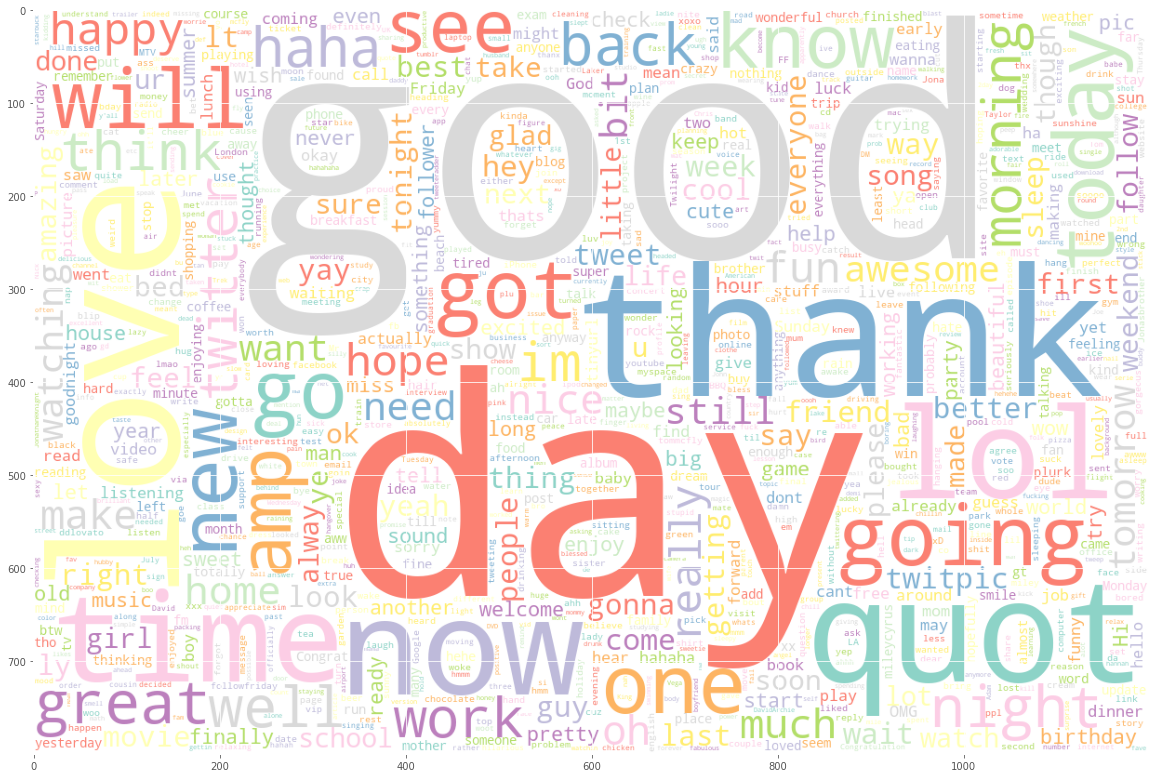

In [ ]:
data_pos = data['text'][800000:]
wc = WordCloud(max_words = 1000 , width = 1200 ,background_color = "white", colormap='Set3', height = 800,
              collocations=False).generate(" ".join(data_pos))
plt.figure(figsize = (20,20))
plt.imshow(wc)

In [ ]:
print(df.nunique())
df['weekday'] =  pd.to_datetime(df['date'], format='%a %b %d %H:%M:%S PDT %Y').dt.weekday
X_train2, X_test2, Y_train2, Y_test2 = train_test_split(df['weekday'], y, test_size=0.3, random_state=2)
df2 = pd.DataFrame()
df3 = pd.DataFrame()

y_preds = y_preds.flatten()

df2['weekday'] = X_test2
df2['pred'] = y_preds

df3['weekday'] = X_train2
df3['pred'] = Y_train2

positiveDF=df[df['target']==4]
negativeDF=df[df['target']==0]

positiveDF2=df2[df2['pred']>=.50]
negativeDF2=df2[df2['pred']<.50]

positiveDF3=df3[df3['pred']==1]
negativeDF3=df3[df3['pred']==0]

df3

target          2
ids       1598315
date       774363
flag            1
user       659775
text      1581466
dtype: int64


weekday  pred
782385         3     0
996124         0     1
1251336        0     1
686330         5     0
283834         0     0
...          ...   ...
961799         6     1
1133010        5     1
1486358        6     1
203245         5     0
100879         3     0

[1120000 rows x 2 columns]

In [ ]:
negMon=len(negativeDF[negativeDF['weekday']==0])
negTues=len(negativeDF[negativeDF['weekday']==1])
negWeds=len(negativeDF[negativeDF['weekday']==2])
negThur=len(negativeDF[negativeDF['weekday']==3])
negFri=len(negativeDF[negativeDF['weekday']==4])
negSat=len(negativeDF[negativeDF['weekday']==5])
negSun=len(negativeDF[negativeDF['weekday']==6])

negMon2=len(negativeDF2[negativeDF2['weekday']==0])
negTues2=len(negativeDF2[negativeDF2['weekday']==1])
negWeds2=len(negativeDF2[negativeDF2['weekday']==2])
negThur2=len(negativeDF2[negativeDF2['weekday']==3])
negFri2=len(negativeDF2[negativeDF2['weekday']==4])
negSat2=len(negativeDF2[negativeDF2['weekday']==5])
negSun2=len(negativeDF2[negativeDF2['weekday']==6])

negMon3=len(negativeDF3[negativeDF3['weekday']==0])
negTues3=len(negativeDF3[negativeDF3['weekday']==1])
negWeds3=len(negativeDF3[negativeDF3['weekday']==2])
negThur3=len(negativeDF3[negativeDF3['weekday']==3])
negFri3=len(negativeDF3[negativeDF3['weekday']==4])
negSat3=len(negativeDF3[negativeDF3['weekday']==5])
negSun3=len(negativeDF3[negativeDF3['weekday']==6])

print(negMon,negTues,negWeds,negThur,negFri,negSat, negSun)
print(negMon2,negTues2,negWeds2,negThur2,negFri2,negSat2, negSun2)
print(negMon3,negTues3,negWeds3,negThur3,negFri3,negSat3, negSun3)

132539 101051 68473 80132 114600 157734 145471
44558 30365 18640 21075 34744 49222 47847
92798 70751 48128 56192 80293 110363 101753


In [ ]:
posMon=len(positiveDF[positiveDF['weekday']==0])
posTues=len(positiveDF[positiveDF['weekday']==1])
posWeds=len(positiveDF[positiveDF['weekday']==2])
posThur=len(positiveDF[positiveDF['weekday']==3])
posFri=len(positiveDF[positiveDF['weekday']==4])
posSat=len(positiveDF[positiveDF['weekday']==5])
posSun=len(positiveDF[positiveDF['weekday']==6])

posMon2=len(positiveDF2[positiveDF2['weekday']==0])
posTues2=len(positiveDF2[positiveDF2['weekday']==1])
posWeds2=len(positiveDF2[positiveDF2['weekday']==2])
posThur2=len(positiveDF2[positiveDF2['weekday']==3])
posFri2=len(positiveDF2[positiveDF2['weekday']==4])
posSat2=len(positiveDF2[positiveDF2['weekday']==5])
posSun2=len(positiveDF2[positiveDF2['weekday']==6])

posMon3=len(positiveDF3[positiveDF3['weekday']==0])
posTues3=len(positiveDF3[positiveDF3['weekday']==1])
posWeds3=len(positiveDF3[positiveDF3['weekday']==2])
posThur3=len(positiveDF3[positiveDF3['weekday']==3])
posFri3=len(positiveDF3[positiveDF3['weekday']==4])
posSat3=len(positiveDF3[positiveDF3['weekday']==5])
posSun3=len(positiveDF3[positiveDF3['weekday']==6])
print(posMon, posTues, posWeds,posThur, posFri,posSat, posSun)
print(posMon2, posTues2, posWeds2, posThur2, posFri2, posSat2, posSun2)
print(posMon3, posTues3, posWeds3, posThur3, posFri3, posSat3, posSun3)

177666 84799 28333 25903 110994 173221 199084
48694 25409 10307 10574 32971 49992 55602
124155 59325 19731 18194 77586 121378 139353


In [ ]:
pnRatios=[posMon/negMon, posTues/negTues, posWeds/negWeds, posThur/negThur, posFri/negFri, posSat/negSat, posSun/negSun]
print(pnRatios)

pnRatios2=[posMon2/negMon2, posTues2/negTues2, posWeds2/negWeds2, posThur2/negThur2, posFri2/negFri2, posSat2/negSat2, posSun2/negSun2]
print(pnRatios2)

pnRatios3=[posMon3/negMon3, posTues3/negTues3, posWeds3/negWeds3, posThur3/negThur3, posFri3/negFri3, posSat3/negSat3, posSun3/negSun3]
print(pnRatios3)


[1.3404809150514188, 0.8391703199374573, 0.4137835351160311, 0.3232541306843708, 0.9685340314136126, 1.0981842849353975, 1.3685476830433556]
[1.0928228376498048, 0.8367857730940227, 0.552950643776824, 0.5017319098457889, 0.9489696062629519, 1.0156434114826705, 1.1620791272180073]
[1.3379059893532188, 0.8385040494127292, 0.4099692486702128, 0.32378274487471526, 0.9662859776070143, 1.0998070005345995, 1.3695222745275324]


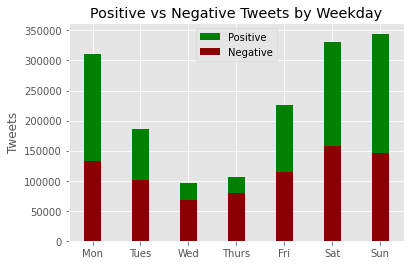

In [ ]:
negatives = [negMon, negTues, negWeds, negThur, negFri, negSat, negSun]
positives = [posMon, posTues, posWeds, posThur, posFri, posSat, posSun]

fig, ax = plt.subplots()
labels = ["Mon", "Tues", "Wed", "Thurs", "Fri", "Sat", "Sun"]
width = .35

ax.bar(labels, positives, width, label='Positive', bottom=negatives, color = 'g')
ax.bar(labels, negatives, width, label='Negative', color = 'darkred')

ax.set_ylabel('Tweets')
ax.set_title('Positive vs Negative Tweets by Weekday')
ax.legend()

plt.show()


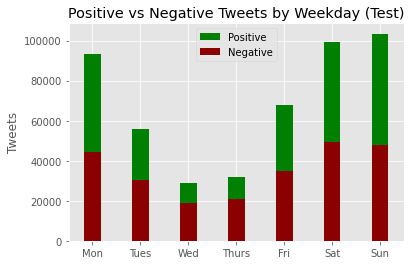

In [ ]:
negatives = [negMon2, negTues2, negWeds2, negThur2, negFri2, negSat2, negSun2]
positives = [posMon2, posTues2, posWeds2, posThur2, posFri2, posSat2, posSun2]

fig, ax = plt.subplots()
labels = ["Mon", "Tues", "Wed", "Thurs", "Fri", "Sat", "Sun"]
width = .35

ax.bar(labels, positives, width, label='Positive', bottom=negatives, color = 'g')
ax.bar(labels, negatives, width, label='Negative', color = 'darkred')

ax.set_ylabel('Tweets')
ax.set_title('Positive vs Negative Tweets by Weekday (Test)')
ax.legend()

plt.show()

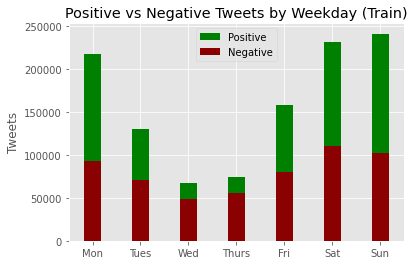

In [ ]:
negatives = [negMon3, negTues3, negWeds3, negThur3, negFri3, negSat3, negSun3]
positives = [posMon3, posTues3, posWeds3, posThur3, posFri3, posSat3, posSun3]

fig, ax = plt.subplots()
labels = ["Mon", "Tues", "Wed", "Thurs", "Fri", "Sat", "Sun"]
width = .35

ax.bar(labels, positives, width, label='Positive', bottom=negatives, color = 'g')
ax.bar(labels, negatives, width, label='Negative', color = 'darkred')

ax.set_ylabel('Tweets')
ax.set_title('Positive vs Negative Tweets by Weekday (Train)')
ax.legend()

plt.show()

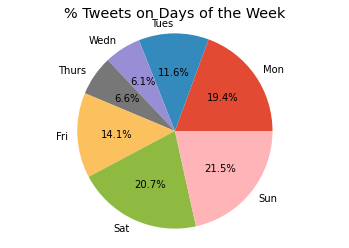

In [ ]:
Mon=len(df[df['weekday']==0])
Tues=len(df[df['weekday']==1])
Weds=len(df[df['weekday']==2])
Thur=len(df[df['weekday']==3])
Fri=len(df[df['weekday']==4])
Sat=len(df[df['weekday']==5])
Sun=len(df[df['weekday']==6])
my_data = (Mon, Tues, Weds, Thur, Fri, Sat, Sun)
my_labels = 'Mon','Tues','Wedn', 'Thurs', 'Fri', 'Sat', 'Sun'
plt.pie(my_data,labels=my_labels,autopct='%1.1f%%')
plt.title('% Tweets on Days of the Week')
plt.axis('equal')
plt.show()